# NGCF: a baseline implementation

## 1. Imports

In [1]:
import torch
import torch.nn as nn
from torch.nn import Module
from scipy.sparse import coo_matrix
from scipy.sparse import vstack
from scipy import sparse
import numpy as np
import pandas as pd
from numpy import diag
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.utils.data import Dataset
from torch.optim import Adam
from torch.nn import MSELoss
from os import path
import io

In [2]:
from google.colab import files
uploaded = files.upload()

Saving data_train.csv to data_train (1).csv


## 2. Utils

### 2.1. Data loader

In [4]:
# load 100k data

def extract_users_items_predictions(data_pd):
    users, movies = \
        [np.squeeze(arr) for arr in np.split(data_pd.Id.str.extract('r(\d+)_c(\d+)').values.astype(int) - 1, 2, axis=-1)]
    predictions = data_pd.Prediction.values
    return users, movies, predictions

def load100KRatings():
    data_pd = pd.read_csv(io.BytesIO(uploaded['data_train.csv']))
    print("BEFORE: ", data_pd.shape)
    users, movies, ratings = extract_users_items_predictions(data_pd)
    df = pd.DataFrame({'userId': users, 'itemId': movies, 'rating': ratings})
    #df = pd.read_table(path100k+r'\u.data',sep='\t',names=['userId','itemId','rating','timestamp'])
    return df


# movielens 1k
class ML1K(Dataset):

    def __init__(self,rt):
        super(Dataset,self).__init__()
        self.uId = list(rt['userId'])
        self.iId = list(rt['itemId'])
        self.rt = list(rt['rating'])

    def __len__(self):
        return len(self.uId)

    def __getitem__(self, item):
        return (self.uId[item],self.iId[item],self.rt[item])



### 2.2. Dimensionality Reduction

In [30]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def pca_exp_plot(ds):
  # Change dataset structure
  movie_ratings_nan = ds.pivot_table(values="rating",index="userId",columns="itemId")
  movie_ratings = movie_ratings_nan.fillna(0)#(movie_ratings_nan.mean())
  # Perform PCA
  pca = PCA().fit(movie_ratings)
  plt.plot(np.cumsum(pca.explained_variance_ratio_))
  plt.xlabel('number of components')
  plt.ylabel('cumulative explained variance')

### 2.3. User-user and Item-item similarity

In [6]:
from scipy.sparse import linalg
from scipy.stats import pearsonr

def normalization(dataframe):
    dataframe_mean = dataframe.mean(axis=1)
    #dataframe_std = dataframe.std(axis=1)
    return dataframe.subtract(dataframe_mean, axis = 'rows')#.divide(dataframe_std, axis = 'rows')

def ii_similarity(ds):
  tmp = ds.pivot_table(values="rating",index="userId",columns="itemId")
  new = tmp.fillna(tmp.mean())
  #return new.transpose().dot(new)
  return new.corr()

def uu_similarity(ds):
  tmp = ds.pivot_table(values="rating",index="userId",columns="itemId")
  new = tmp.fillna(tmp.mean())
  #return new.dot(new.transpose())
  return new.T.corr()



## 4. Main

In [7]:
rt = load100KRatings()
userNum = rt['userId'].max() + 1
itemNum = rt['itemId'].max() + 1

rt['userId'] = rt['userId']
rt['itemId'] = rt['itemId']

rt

BEFORE:  (1176952, 2)


,userId,itemId,rating
0,43,0,4
1,60,0,3
2,66,0,4
3,71,0,3
4,85,0,5
...,...,...,...
1176947,9989,999,4
1176948,9991,999,5
1176949,9993,999,3
1176950,9996,999,4


Dimensionality

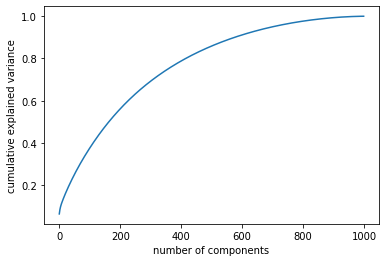

In [31]:
pca_exp_plot(rt)

Similarity

In [9]:
number_of_users, number_of_movies = (10000, 1000)
k_singular_values = 2
number_of_singular_values = min(number_of_users, number_of_movies)

data_temp = rt.pivot_table(values="rating",index="userId",columns="itemId")
data = data_temp.fillna(data_temp.mean())

assert(k_singular_values <= number_of_singular_values), "choose correct number of singular values"

U, s, Vt = np.linalg.svd(data, full_matrices=False)

S = np.zeros((number_of_movies, number_of_movies))
S[:k_singular_values, :k_singular_values] = np.diag(s[:k_singular_values])

reconstructed_matrix = U.dot(S).dot(Vt)

In [27]:
uu_sim = uu_similarity(rt)

In [32]:
ii_sim = ii_similarity(rt)

In [ ]:
import seaborn as sns
sns.heatmap(uu_sim, annot = True)

In [ ]:
import seaborn as sns
sns.heatmap(ii_sim, annot = True)

Clustering

In [28]:
print(__doc__)

import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler


# #############################################################################
# Generate sample data
# centers = [[1, 1], [-1, -1], [1, -1]]
# X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
#                             random_state=0)

# X = StandardScaler().fit_transform(X)
# Change dataset structure
# movie_ratings_nan = rt.pivot_table(values="rating",index="userId",columns="itemId")
# movie_ratings = movie_ratings_nan.fillna(0)#(movie_ratings_nan.mean())
# X = movie_ratings.to_numpy()

X = reconstructed_matrix

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.03, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
print(labels)

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    # xy = X[class_member_mask & ~core_samples_mask]
    # plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
    #          markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

Automatically created module for IPython interactive environment
[-1 -1 -1 ... -1 -1 -1]
Estimated number of clusters: 0
Estimated number of noise points: 10000


ValueError: ignored